#Transfer tif to png (done in local, need to be updated in jupyter notebook)
import cv2
import os
import numpy as np

path = os.getcwd()
print(path)

imagesDirectory= os.path.join(path,"sr_data")  # tif image directory
distDirectory = os.path.dirname(imagesDirectory)
distDirectory = os.path.join(distDirectory, "sr_png")# save directory

for imageName in os.listdir(imagesDirectory):
    imagePath = os.path.join(imagesDirectory, imageName)
    image = cv2.imread(imagePath)# open tif image
    img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    distImagePath = os.path.join(distDirectory, imageName[:-4]+'.png')# save imgaes
    cv2.imwrite(distImagePath,img)# write imgaes

In [ ]:
#Traninig

In [8]:
import argparse
import os
import numpy as np
import math
import itertools
import sys


import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)


epoch=0
n_epochs=50
#dataset_name="img_hr"
batch_size=5
lr=0.0002
b1=0.5
b2=0.999
decay_epoch=100
n_cpu=8
hr_height=512
hr_width=512
channels=1
sample_interval=10
checkpoint_interval=-1

cuda = torch.cuda.is_available()

hr_shape = (hr_height, hr_width)

# Initialize generator and discriminator
generator = GeneratorResNet(in_channels=channels, out_channels=channels)
discriminator = Discriminator(input_shape=(channels, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

if epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("saved_models/generator_%d.pth"))
    discriminator.load_state_dict(torch.load("saved_models/discriminator_%d.pth"))

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

dataloader = DataLoader(
    #ImageDataset("../../data/%s" % opt.dataset_name, hr_shape=hr_shape),
    ImageDataset("../../data/", hr_shape=hr_shape),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

# ----------
#  Training
# ----------

Dloss=[]
Gloss=[]

for epoch in range(epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # Configure model input
        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        # Content loss
    #    gen_features = feature_extractor(gen_hr)
        gen_features = feature_extractor(torch.cat((gen_hr,gen_hr,gen_hr),1))
    #    real_features = feature_extractor(imgs_hr)
        real_features = feature_extractor(torch.cat((imgs_hr,imgs_hr,imgs_hr),1))
    #    loss_content = criterion_content(gen_features, real_features.detach())
        loss_content = criterion_content(gen_hr, imgs_hr.detach()) + criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        Dloss.append(loss_D.item())
        Gloss.append(loss_G.item())

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
            imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
            imgs_hr = make_grid(imgs_hr, nrow=1,normalize=True)
            img_grid = torch.cat((imgs_lr, gen_hr, imgs_hr), -1)
            save_image(img_grid, "images/%d.png" % batches_done, normalize=False)
             #print("batch_done:%d\n" %batches_done)           
    
    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" % epoch)


[Epoch 0/50] [Batch 0/40] [D loss: 0.884795] [G loss: 1.275034]
[Epoch 0/50] [Batch 1/40] [D loss: 5.604547] [G loss: 1.052239]
[Epoch 0/50] [Batch 2/40] [D loss: 0.611576] [G loss: 0.763492]
[Epoch 0/50] [Batch 3/40] [D loss: 0.810390] [G loss: 0.395291]
[Epoch 0/50] [Batch 4/40] [D loss: 1.298197] [G loss: 0.297291]
[Epoch 0/50] [Batch 5/40] [D loss: 0.412575] [G loss: 0.146483]
[Epoch 0/50] [Batch 6/40] [D loss: 0.307838] [G loss: 0.125418]
[Epoch 0/50] [Batch 7/40] [D loss: 0.275373] [G loss: 0.119606]
[Epoch 0/50] [Batch 8/40] [D loss: 0.335270] [G loss: 0.141718]
[Epoch 0/50] [Batch 9/40] [D loss: 0.267142] [G loss: 0.106827]
[Epoch 0/50] [Batch 10/40] [D loss: 0.268014] [G loss: 0.097686]
[Epoch 0/50] [Batch 11/40] [D loss: 0.246957] [G loss: 0.105676]
[Epoch 0/50] [Batch 12/40] [D loss: 0.245689] [G loss: 0.116798]
[Epoch 0/50] [Batch 13/40] [D loss: 0.225071] [G loss: 0.080320]
[Epoch 0/50] [Batch 14/40] [D loss: 0.213471] [G loss: 0.134253]
[Epoch 0/50] [Batch 15/40] [D loss:

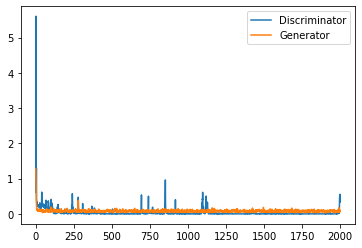

In [9]:
from matplotlib import pyplot
pyplot.plot(Dloss, label='Discriminator')
pyplot.plot(Gloss, label='Generator')
pyplot.legend()
pyplot.show()


In [10]:
pyplot.savefig('100samples.jpg')
print(Dloss)
print(Gloss)


[0.8847947120666504, 5.604546546936035, 0.6115759015083313, 0.8103896379470825, 1.2981972694396973, 0.41257452964782715, 0.3078382909297943, 0.2753731608390808, 0.3352704644203186, 0.2671424448490143, 0.268013596534729, 0.24695651233196259, 0.24568873643875122, 0.22507089376449585, 0.21347106993198395, 0.2078537940979004, 0.24284464120864868, 0.22488754987716675, 0.2598460912704468, 0.2203635573387146, 0.2038748562335968, 0.19885170459747314, 0.18452852964401245, 0.19225037097930908, 0.23612606525421143, 0.19686877727508545, 0.31312596797943115, 0.22223038971424103, 0.2673870325088501, 0.21067805588245392, 0.1420634388923645, 0.16092056035995483, 0.19478309154510498, 0.16063494980335236, 0.1551741510629654, 0.1200871467590332, 0.1646941900253296, 0.30035150051116943, 0.30178725719451904, 0.617984414100647, 0.35666584968566895, 0.2879921793937683, 0.28049540519714355, 0.2537909150123596, 0.2671101987361908, 0.2607812285423279, 0.2323024570941925, 0.2299100160598755, 0.21938984096050262,

<Figure size 432x288 with 0 Axes>

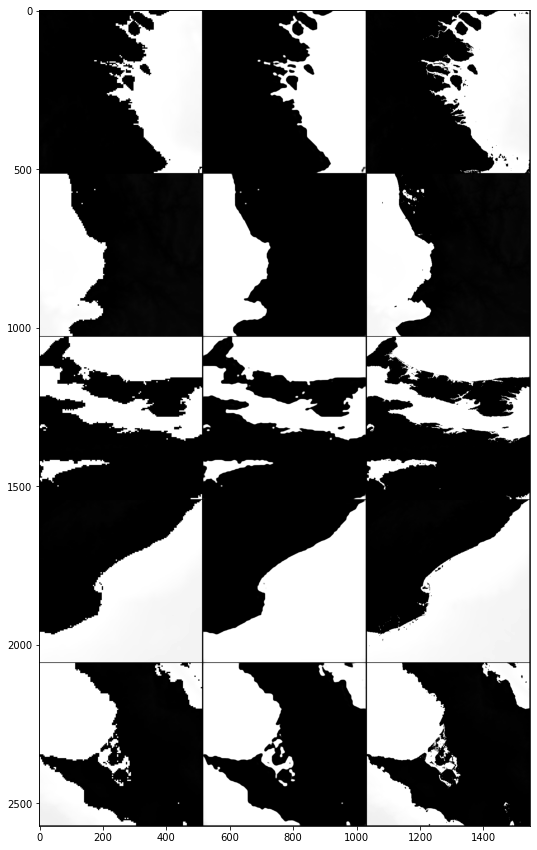

In [11]:
import matplotlib.pyplot as plt
fig, axes=plt.subplots(1,1,figsize=(9,15))
axes.imshow(img_grid.cpu().numpy()[0], cmap='gray') 